In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Machine Learning
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import linear_model,preprocessing
from sklearn import tree
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from prettytable import PrettyTable 

In [7]:
dataFrame = pd.read_csv('../files/card_transdata.csv')
dataFrame.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [8]:
count = dataFrame['fraud'].value_counts()

totalTransactions = count[1] + count[0]
noFrauds = count[1]
fraudRate = noFrauds/totalTransactions * 100

print("Number of frauds: " + str(noFrauds))
print("Number of transactions: " + str(totalTransactions))
print("Frauds Percentage: " + str(fraudRate))


Number of frauds: 87403
Number of transactions: 1000000
Frauds Percentage: 8.7403


In [9]:
#Dealing with missing data
dataFrame.isna().sum()
dataFrame.isnull().sum()
dataFrame = pd.read_csv('../files/card_transdata.csv', na_values=['NA'])
dataFrame.dropna()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


There aren't any missing values in this data set.

There aren't any null values in this data set.

In [10]:
#Dealing with duplicated data
length = len(dataFrame)
dataFrame.drop_duplicates(keep = False)
cleanedDups = len(dataFrame)

print("Before removing duplicated values: " + str(length))
print("After removing duplicated values: " + str(cleanedDups))

if length == cleanedDups:
    print("There aren't any duplicated objects")

Before removing duplicated values: 1000000
After removing duplicated values: 1000000
There aren't any duplicated objects


In [11]:
dataFrame.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
dataFrame = dataFrame.sample(100000)

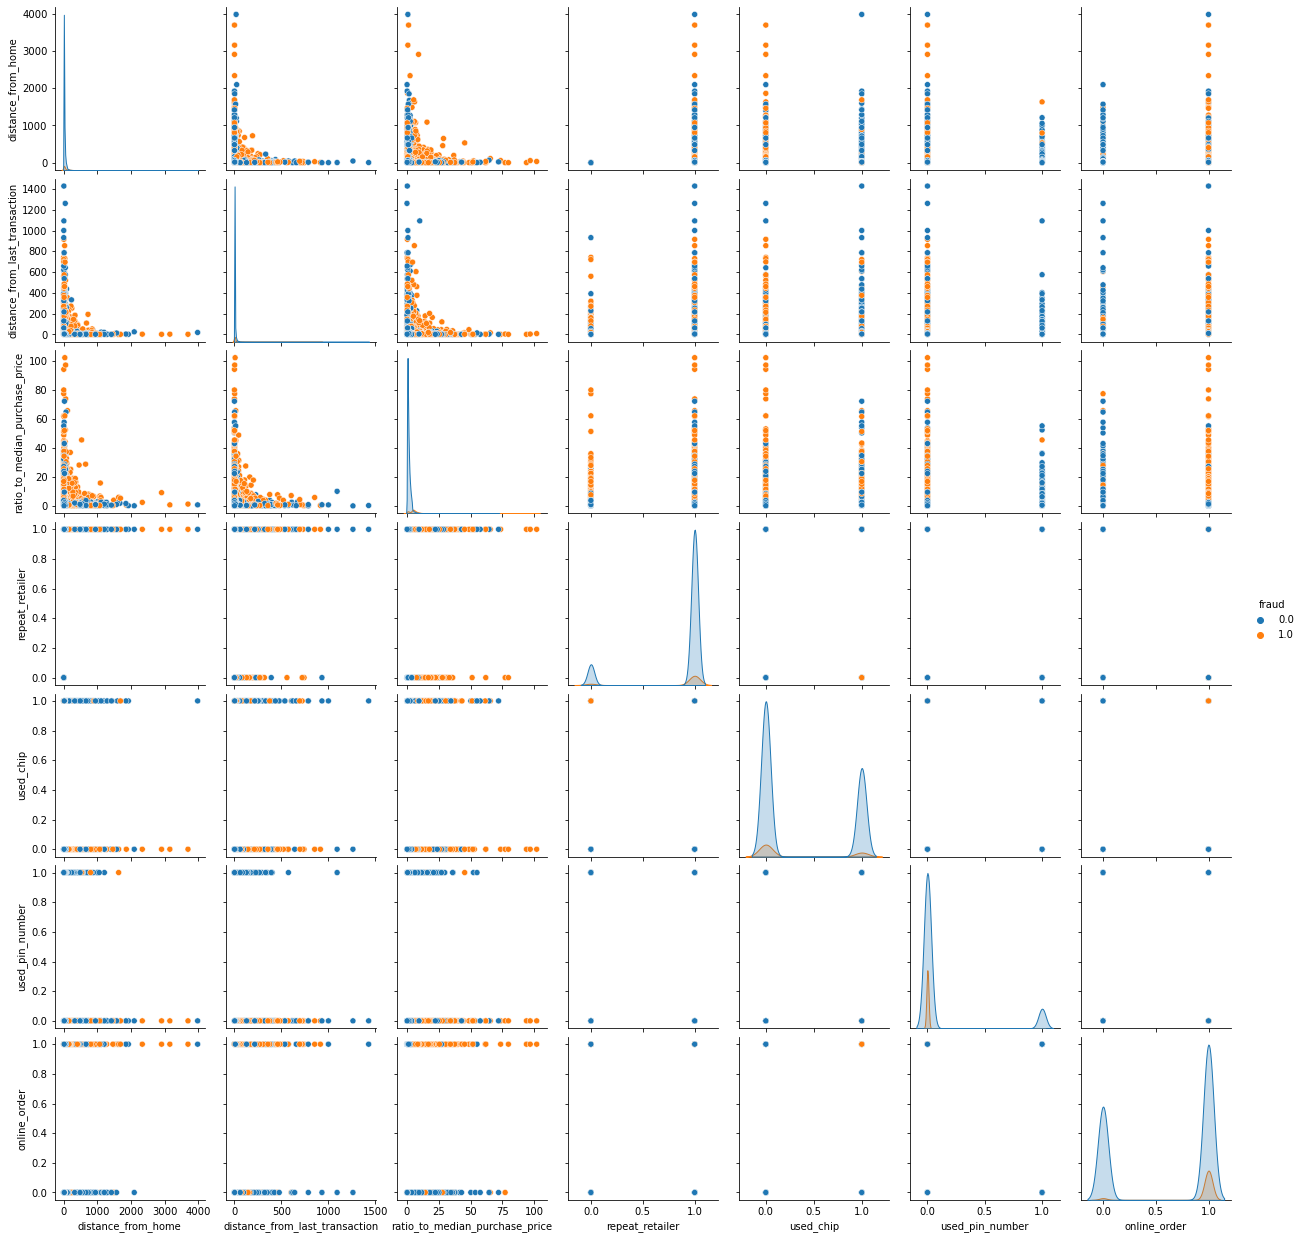

In [13]:
%matplotlib inline

sns.pairplot(dataFrame, hue='fraud')

In [14]:
dataFrame.columns

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')

In [15]:
feature = ['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order']

x = dataFrame[feature]
x

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
361532,0.240393,0.439616,0.207655,0.0,0.0,0.0,1.0
808956,5.529963,2.277230,3.987790,1.0,0.0,0.0,1.0
419333,14.954297,0.135055,3.817962,1.0,1.0,0.0,0.0
998377,12.022042,0.532665,0.334744,1.0,1.0,0.0,0.0
380007,63.562345,8.786189,1.299287,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...
263409,22.918327,3.610937,2.299474,1.0,0.0,0.0,1.0
295737,6.238991,0.886087,8.537526,1.0,1.0,0.0,1.0
187955,13.896784,9.911931,1.343763,1.0,0.0,0.0,1.0
205050,10.905565,1.532157,0.166342,1.0,0.0,0.0,0.0


Defining a Function for Train and Test split - split is done on 80% train and 20% test (can be altered in test_size value). Initially done including all features.

In [36]:
def declare_train_and_test(target_col, cols, delim=",", normalize=True):
    target = [cols[target_col]]
    print ("Target Feature :", target)
    features = cols[0:target_col]
    features += cols[target_col+1:]
    print ("Features column :", features)
    
    df = pd.read_csv('../files/card_transdata.csv')
    df.fillna(value=0,inplace=True)
    x_dataFrame = df[features]
    y_dataFrame = df[target]
    x_data = np.array(pd.DataFrame(x_dataFrame, columns = features))
    y_data = np.array(pd.DataFrame(x_dataFrame, columns = target))
      

    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
    print (x_train.shape)
    return x_train, y_train, x_test, y_test

column_names = ["distance_from_home","distance_from_last_transaction","ratio_to_median_purchase_price","repeat_retailer","used_chip","used_pin_number","online_order","fraud"
]
x_train, y_train, x_test, y_test =declare_train_and_test( 7,cols=column_names)
print(x_train,y_train)

Target Feature : ['fraud']
Features column : ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']
(800000, 7)
[[57.87785658  0.31114001  1.94593998 ...  1.          0.
   0.        ]
 [10.8299427   0.1755915   1.29421881 ...  0.          0.
   0.        ]
 [ 5.09107949  0.80515259  0.42771456 ...  0.          0.
   1.        ]
 ...
 [ 7.29333654  0.9949192   0.6795783  ...  0.          0.
   1.        ]
 [12.61886867  3.82897591  1.87159267 ...  0.          0.
   1.        ]
 [ 2.10108365 10.51833128  0.53783513 ...  0.          0.
   1.        ]] [[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


In [32]:
# Decision Tree model
des_tree_model = DecisionTreeClassifier()
drawing= des_tree_model.fit(x_train, y_train)
y_test_pred = des_tree_model.predict(x_test)
y_train_pred = des_tree_model.predict(x_train)
Accuracy_Test=accuracy_score(y_test, y_test_pred) * 100
Accuracy_Test= str(Accuracy_Test) + " %"
Accuracy_Train=accuracy_score(y_train, y_train_pred) * 100
Accuracy_Train= str(Accuracy_Train) + " %"
Train_Data_Score=des_tree_model.score(x_train, y_train) * 100
Train_Data_Score= str(Train_Data_Score) + " %"


#Construction of confusion matrix
confmat_train = confusion_matrix(y_train_pred, y_train)
confmat_test =  confusion_matrix(y_test_pred, y_test)
print ("\nConfusion matrix of Train Data\n", confmat_train)
print ("\nConfusion matrix of Test Data\n", confmat_test)
total=sum(sum(confmat_test))


#Calculation of Specificity
#Specificity = TN/(TN+FP)
sp = confmat_test[1,1]/(confmat_test[1,0]+confmat_test[1,1]) * 100
sp= str(sp) + " %"


#Calculation of sensitivity
#Sensitivity= TP/(TP+FN)
sensi = confmat_test[0,0]/(confmat_test[0,0]+confmat_test[0,1]) * 100
sensi= str(sensi) + " %"



myTable = PrettyTable(["Peformance Paramters", "Value"]) 
#Insert rows
myTable.add_row(["Accuracy of Test Data",Accuracy_Test]) 
myTable.add_row(["Accuracy of Train Data", Accuracy_Train]) 
myTable.add_row(["Data score of Train Data",Train_Data_Score]) 
myTable.add_row(["Specificity of the confusion matrix",sp]) 
myTable.add_row(["Sensitivity of the confusion matrix",sensi])

#print Output
print(myTable)


Confusion matrix of Train Data
 [[730098      0]
 [     0  69902]]

Confusion matrix of Test Data
 [[182499      1]
 [     0  17500]]
+-------------------------------------+---------------------+
|         Peformance Paramters        |        Value        |
+-------------------------------------+---------------------+
|        Accuracy of Test Data        |      99.9995 %      |
|        Accuracy of Train Data       |       100.0 %       |
|       Data score of Train Data      |       100.0 %       |
| Specificity of the confusion matrix |       100.0 %       |
| Sensitivity of the confusion matrix | 99.99945205479452 % |
+-------------------------------------+---------------------+


In [33]:
# Confusion matrix of the Decision Tree
import matplotlib.pyplot as plt
%matplotlib inline  

def plot_confusionmat(cm, lab, test_or_train):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    f = ax.matshow(cm, cmap=plt.cm.turbo)
    plt.title('Confusion Matrix of the ' + test_or_train +' Decision Tree \n')
    fig.colorbar(f)
    ax.set_xticklabels([''] + lab)
    ax.set_yticklabels([''] + lab)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    s = [['TP','FN'], ['FP', 'TN']]
    for k in range(2):
        for l in range(2):
            plt.text(l,k, str(cm[k][l]))
    plt.show()

C:\Users\Juan Bellon\AppData\Local\Temp\ipykernel_9888\1066701508.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + lab)
C:\Users\Juan Bellon\AppData\Local\Temp\ipykernel_9888\1066701508.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + lab)


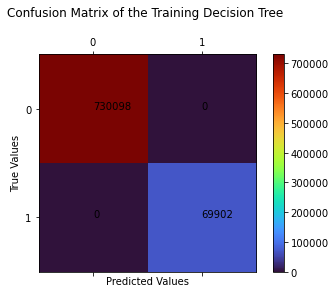

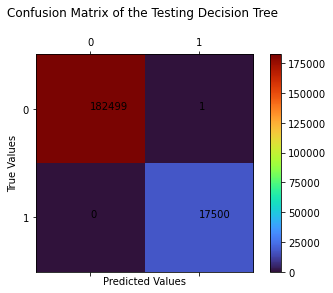

In [34]:
plot_confusionmat(confmat_train, ["0","1"], "Training")
plot_confusionmat(confmat_test, ["0","1"], "Testing")

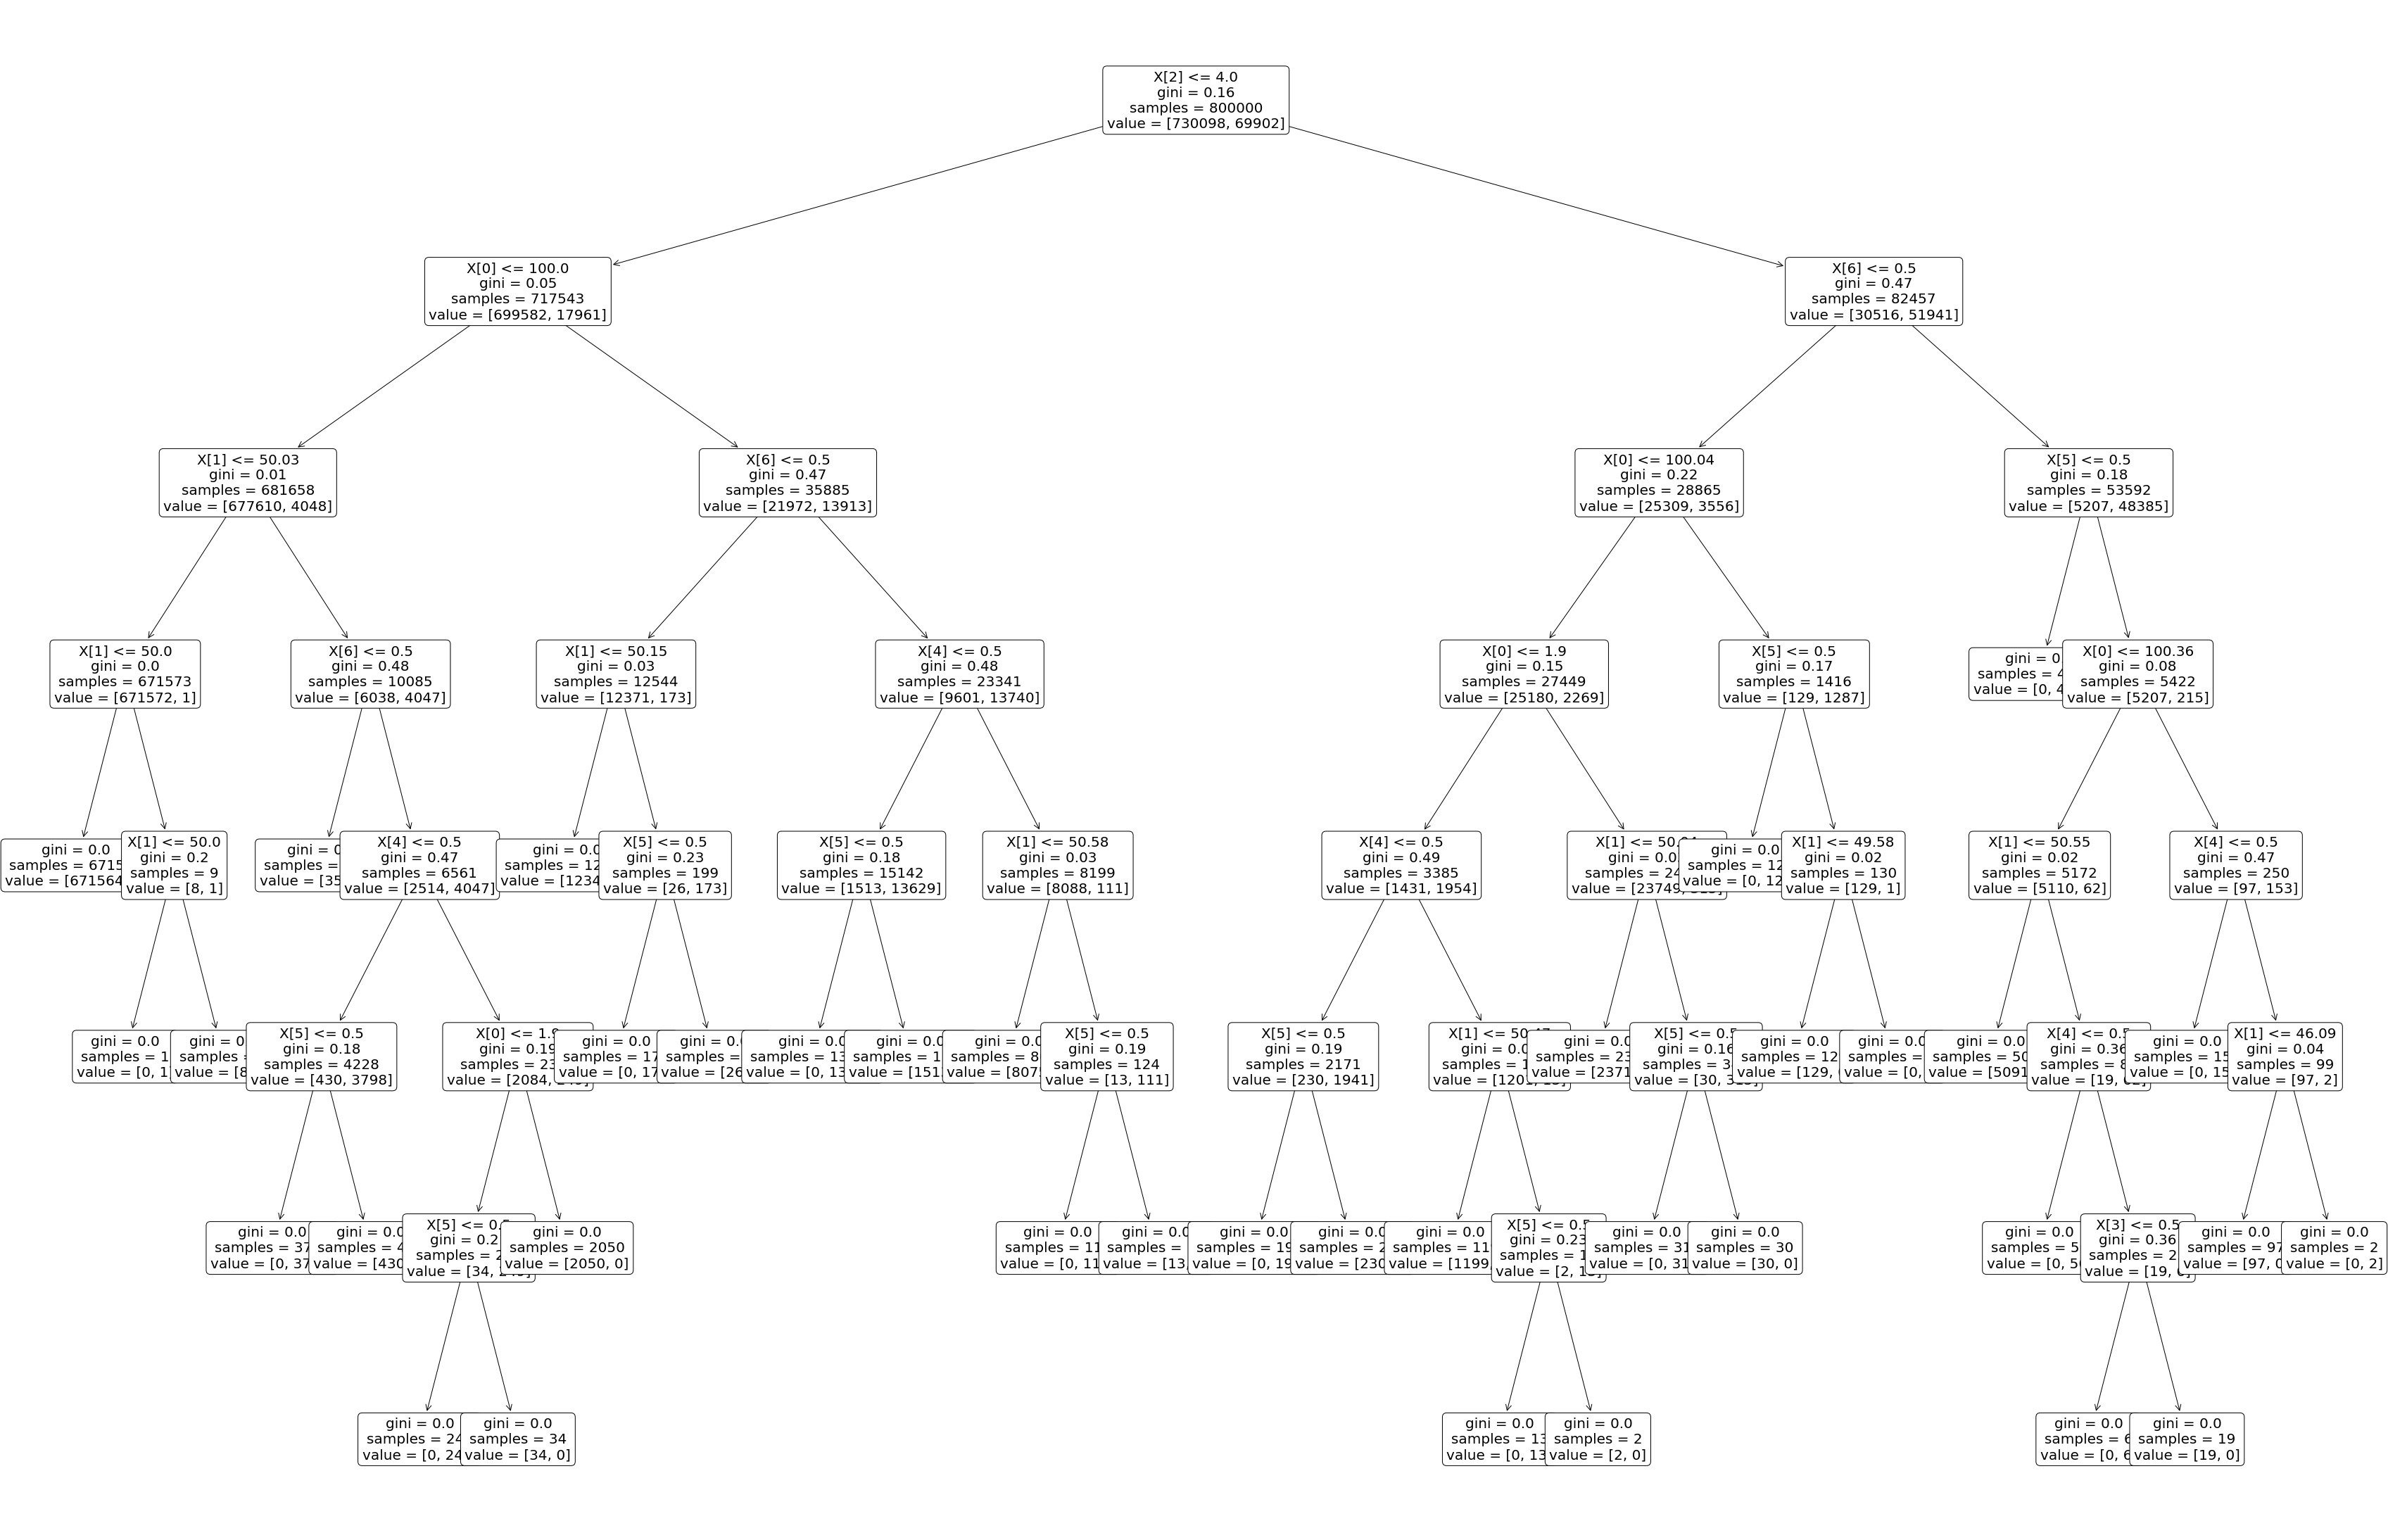

In [35]:
#Decision Tree Drawing :
plt.figure(figsize=[60,40])
tree.plot_tree(des_tree_model,fontsize=20, rounded=True,impurity=True, precision=2)
#tree.plot_tree(drawing,fontsize=20, rounded=True,impurity=True, precision=2)
plt.show()

1. Modeling

In [ ]:
y = dataFrame['fraud']
X = dataFrame.drop('fraud', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

2. Pre-processing

In [ ]:
# List of continuous features
conts = list(dataFrame.columns[:3])

# List of categorical (0/1) features
cats = list(dataFrame.columns[3:-1])

transformations = [('continuous', StandardScaler(), conts), ('categorical', OrdinalEncoder(), cats)]
pipeline = ColumnTransformer(transformations)

In [ ]:
train_transformed = pipeline.fit_transform(X_train)

3. Baseline Model

In [ ]:
baseline = LogisticRegression(max_iter=110)

In [ ]:
baseline.fit(train_transformed, y_train)

In [ ]:
test_transformed = pipeline.transform(X_test)

baseline_preds = baseline.predict(test_transformed)

In [ ]:
baseline.score(test_transformed, y_test)

In [ ]:
confusion_matrix(y_test, baseline_preds)

In [ ]:
precision_score(y_test, baseline_preds)

In [ ]:
recall_score(y_test, baseline_preds)

4. Complex Model

In [ ]:
svc_clf = SVC(kernel='rbf', gamma='auto')

In [ ]:
svc_clf.fit(train_transformed, y_train)

In [ ]:
svc_clf.score(test_transformed, y_test)

In [ ]:
svc_preds = svc_clf.predict(test_transformed)

In [ ]:
confusion_matrix(y_test, svc_preds)

In [ ]:
precision_score(y_test, svc_preds)

In [ ]:
recall_score(y_test, svc_preds)